In [2]:
from Net import *
from Transforms import *
from VideoUtils import *
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as co
import cv2
from torchvision import transforms
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
model = HydraNet()

In [4]:
# model.mobilenet_encoder()

In [5]:
# model.refinenet_decoder()

In [6]:
model.initialize_weights()

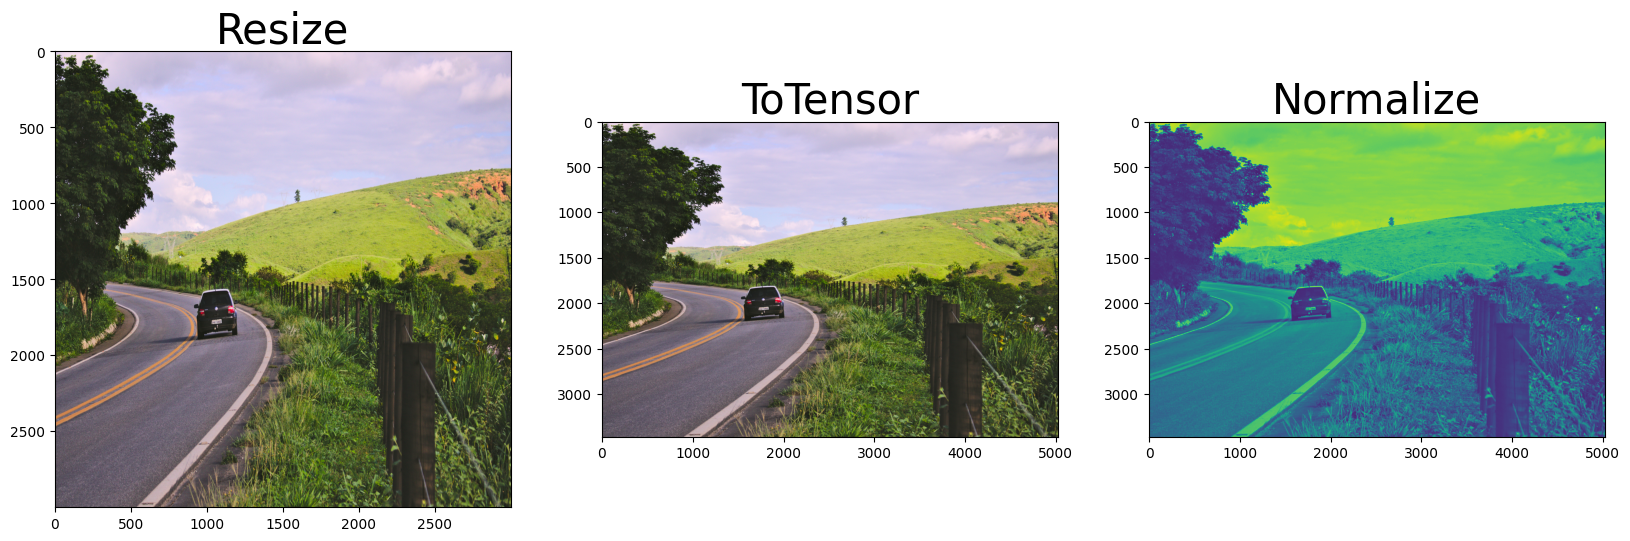

In [7]:
img = np.array(Image.open('test_image.jpg'))
plt.figure(figsize=(20,20))

rescale = Resize((3000,3000))
normalize = Normalize()
toTensor = ToTensor()
composed = transforms.Compose([rescale,toTensor, normalize])

for i, tx in enumerate([rescale,toTensor,normalize]):

    test_transformed = tx(img)
    ax = plt.subplot(1,3, i+1)
    ax.set_title(type(tx).__name__, fontdict={'fontsize': 30})
    plt.imshow(test_transformed)

plt.show()

In [8]:
scale = Scale()
test_image = torch.from_numpy(scale(rescale(img)).transpose(2,0,1)[None]).float()

In [9]:
if torch.cuda.is_available():
    _ = model.cuda() # gpu
    test_image = test_image.cuda()
_ = model.eval() # eval mode

In [10]:
ckpt = torch.load('KITTI.ckpt')
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [11]:
CMAP = np.load('cmap.npy')
NUM_CLASSES = 6

In [12]:
with torch.no_grad():
    depth, segm = model(test_image)
    segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                    img.shape[:2][::-1],
                    interpolation=cv2.INTER_LANCZOS4)
    depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                    img.shape[:2][::-1],
                    interpolation=cv2.INTER_LANCZOS4)
    segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
    depth = np.abs(depth)

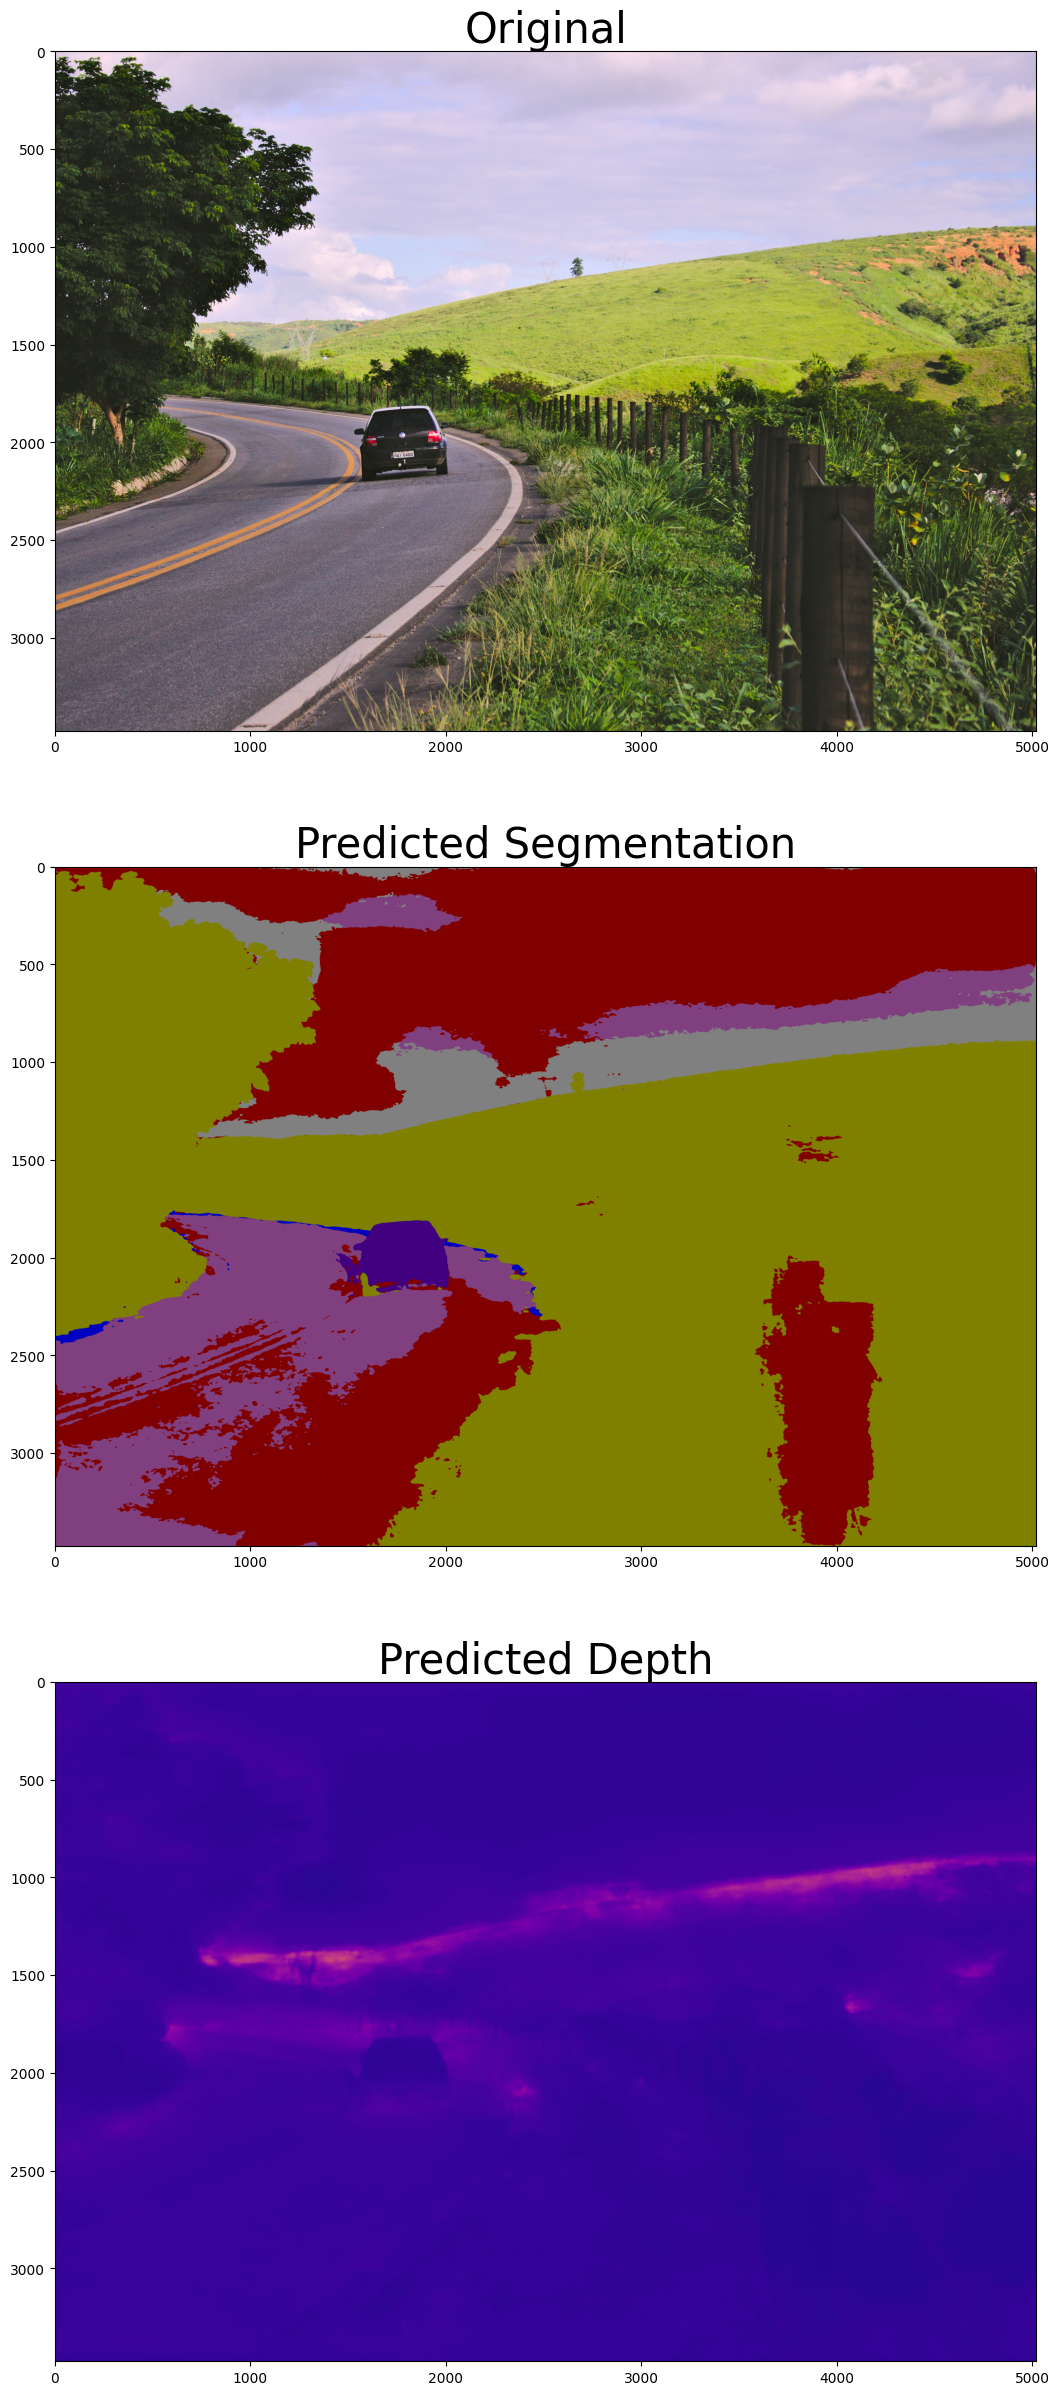

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 30))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth, cmap="plasma", vmin=0, vmax=80)
ax3.set_title("Predicted Depth", fontsize=30)
plt.show()